In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from matplotlib.patches import Ellipse
import io
from contextlib import redirect_stdout

In [10]:
df1 = pd.read_csv('datasets/real-world-data/class1.txt', sep=r'\s+', header=None, names=['x', 'y'])
df2 = pd.read_csv('datasets/real-world-data/class2.txt', sep=r'\s+', header=None, names=['x', 'y'])
df3 = pd.read_csv('datasets/real-world-data/class3.txt', sep=r'\s+', header=None, names=['x', 'y'])


# Add class labels
df1['class'] = 0
df2['class'] = 1
df3['class'] = 2
df = pd.concat([df1, df2, df3], ignore_index=True)

In [11]:
df.describe()

,x,y,class
count,7233.000000,7233.000000,7233.000000
mean,422.661867,1209.809856,1.022536
std,94.425117,611.982823,0.809694
min,3.906250,320.312500,0.000000
25%,367.187500,761.718750,0.000000
50%,421.875000,851.562500,1.000000
75%,476.562500,2035.156250,2.000000
max,2078.125000,2296.875000,2.000000


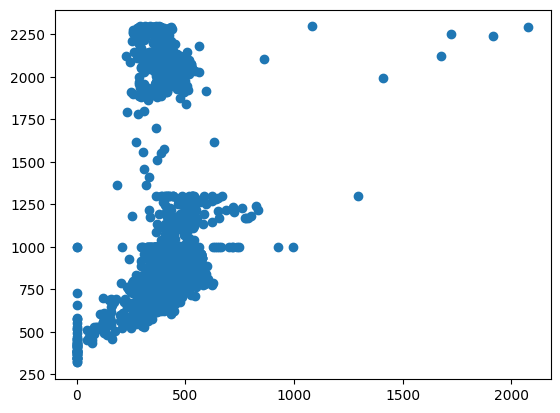

In [12]:
plt.scatter(df['x'], df['y'])
plt.show()

In [13]:
# Draw ellipse for GMM visualization
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))


In [14]:
# Map cluster labels to true class labels - more accurate approach
def map_labels(y_true, y_pred):
    # Create a confusion matrix-like structure
    clusters = np.unique(y_pred)
    classes = np.unique(y_true)

    n_clusters = len(clusters)
    n_classes = len(classes)

    # Count mappings between clusters and true classes
    cluster_class_counts = np.zeros((n_clusters, n_classes), dtype=int)

    # Fill the counts
    for i, cluster in enumerate(clusters):
        for j, cls in enumerate(classes):
            cluster_class_counts[i, j] = np.sum((y_pred == cluster) & (y_true == cls))

    # Assign each cluster to the best class
    unassigned_clusters = list(range(n_clusters))
    unassigned_classes = list(range(n_classes))

    # Initialize mapping dictionary
    mapping = {}

    # Assign the cluster with highest count for each class
    while unassigned_clusters and unassigned_classes:
        # Find the maximum count
        max_count = 0
        max_i, max_j = -1, -1

        for i in unassigned_clusters:
            for j in unassigned_classes:
                if cluster_class_counts[i, j] > max_count:
                    max_count = cluster_class_counts[i, j]
                    max_i, max_j = i, j

        if max_count == 0:  # No more matches found
            break

        # Assign this cluster to this class
        mapping[clusters[max_i]] = classes[max_j]
        unassigned_clusters.remove(max_i)
        unassigned_classes.remove(max_j)

    # Handle any remaining unassigned clusters - assign to most frequent class
    for i in unassigned_clusters:
        if np.sum(y_pred == clusters[i]) > 0:  # If this cluster has any points
            # Find the class with most overlap
            class_counts = [np.sum((y_pred == clusters[i]) & (y_true == cls)) for cls in classes]
            mapping[clusters[i]] = classes[np.argmax(class_counts)]

    # Apply mapping with a default to the most common class
    most_common_class = np.bincount(y_true.astype(int)).argmax()
    y_mapped = np.array([mapping.get(label, most_common_class) for label in y_pred])

    return y_mapped


In [15]:

# Function to capture log likelihood values during GMM fitting
def fit_gmm_with_log_likelihood(gmm, X):
    # Redirect stdout to capture verbose output
    f = io.StringIO()
    with redirect_stdout(f):
        # Set verbose to print likelihood values at each iteration
        gmm.verbose = 2
        gmm.verbose_interval = 1
        gmm.fit(X)

    # Get output and parse log likelihood values
    output = f.getvalue()
    ll_changes = []
    final_ll = None

    for line in output.split('\n'):
        if 'Iteration' in line and 'll change' in line:
            parts = line.split()
            if len(parts) >= 8:
                # Extract the log likelihood change
                ll_change = float(parts[7])
                ll_changes.append(ll_change)
        elif 'converged:' in line and 'll' in line:
            # Extract the final log-likelihood
            parts = line.split()
            for i, part in enumerate(parts):
                if part == 'll':
                    final_ll = float(parts[i+1])
                    break

    # Calculate actual log likelihood values
    log_likelihood_history = []

    if final_ll is not None and len(ll_changes) > 0:
        # Start with the final log-likelihood
        current_ll = final_ll
        log_likelihood_history = [current_ll]

        # Work backwards using the changes
        for change in reversed(ll_changes[1:]):
            current_ll = current_ll - change
            log_likelihood_history.append(current_ll)

        # Reverse to get chronological order
        log_likelihood_history.reverse()
    else:
        # Fallback if we couldn't parse the final log-likelihood
        # Get total log-likelihood from the model
        total_ll = gmm.score(X) * X.shape[0]

        if len(ll_changes) > 0:
            # Start with the final value
            log_likelihood_history = [total_ll]

            # Work backwards from the final log-likelihood
            for change in reversed(ll_changes[1:]):
                log_likelihood_history.append(log_likelihood_history[-1] - change)

            # Reverse to get values in chronological order
            log_likelihood_history.reverse()

    return gmm, log_likelihood_history


In [16]:
# Prepare data
X = df[['x', 'y']].values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# List of mixture components to try
n_mixtures = [1, 2, 4, 8, 16, 32, 64]

# Create empty lists to store metrics
all_metrics = []


==== GMM with 1 components ====
Accuracy: 0.3382, Precision: 0.1127, Recall: 0.3333, F1: 0.1685


/Users/abheygupta/Documents/isl/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


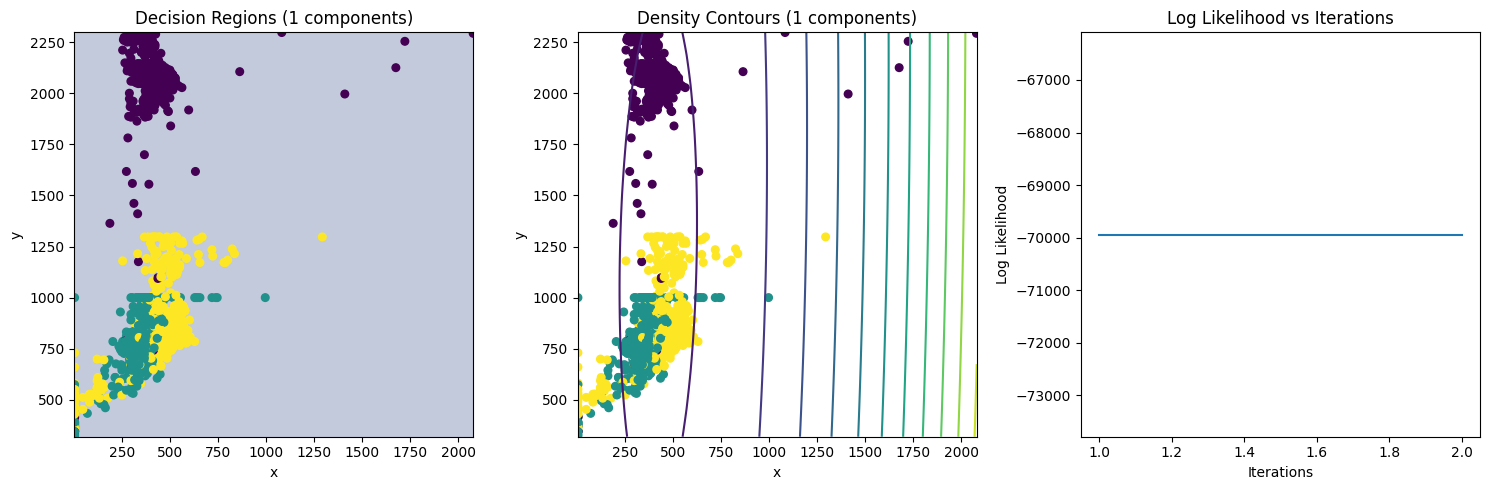


==== GMM with 2 components ====
Accuracy: 0.6613, Precision: 0.4999, Recall: 0.6638, F1: 0.5540


/Users/abheygupta/Documents/isl/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


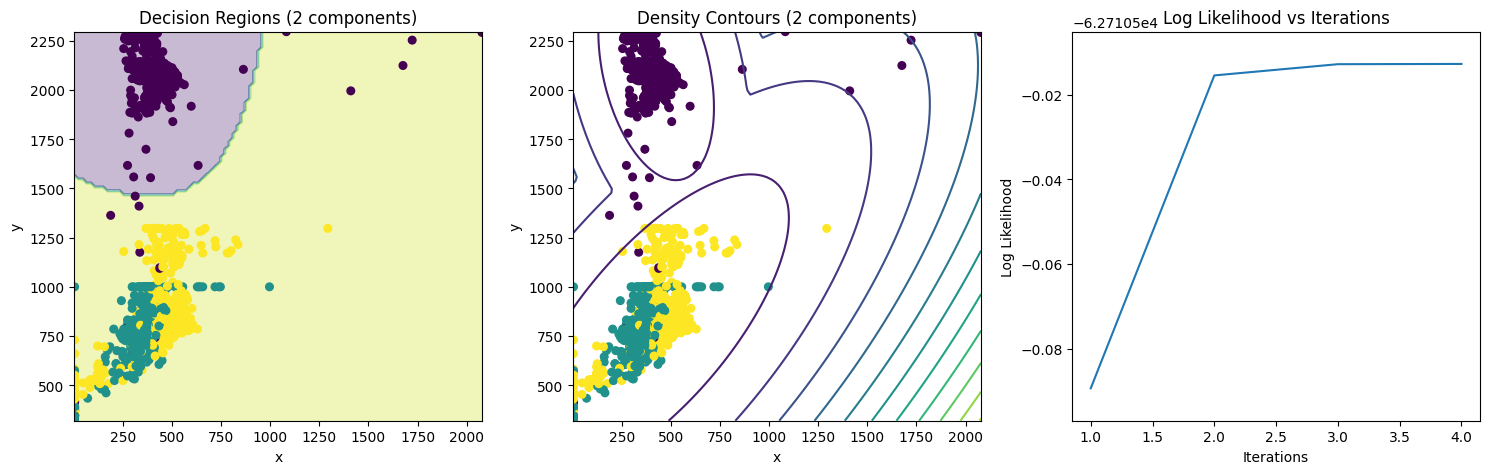


==== GMM with 4 components ====
Accuracy: 0.6719, Precision: 0.6932, Recall: 0.6744, F1: 0.6094


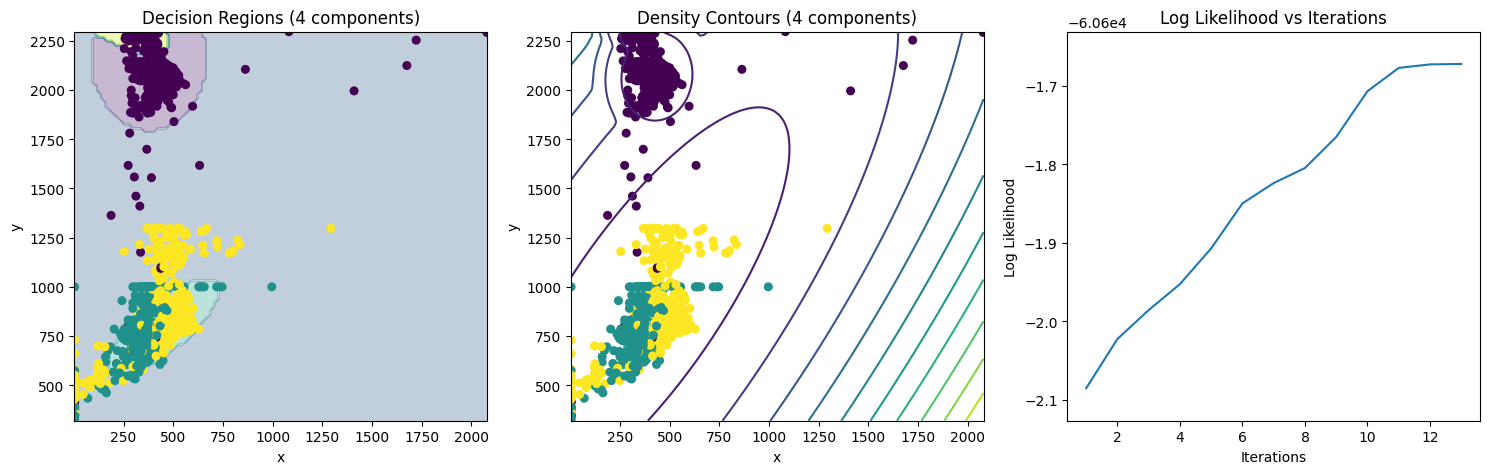


==== GMM with 8 components ====
Accuracy: 0.8908, Precision: 0.9009, Recall: 0.8921, F1: 0.8914


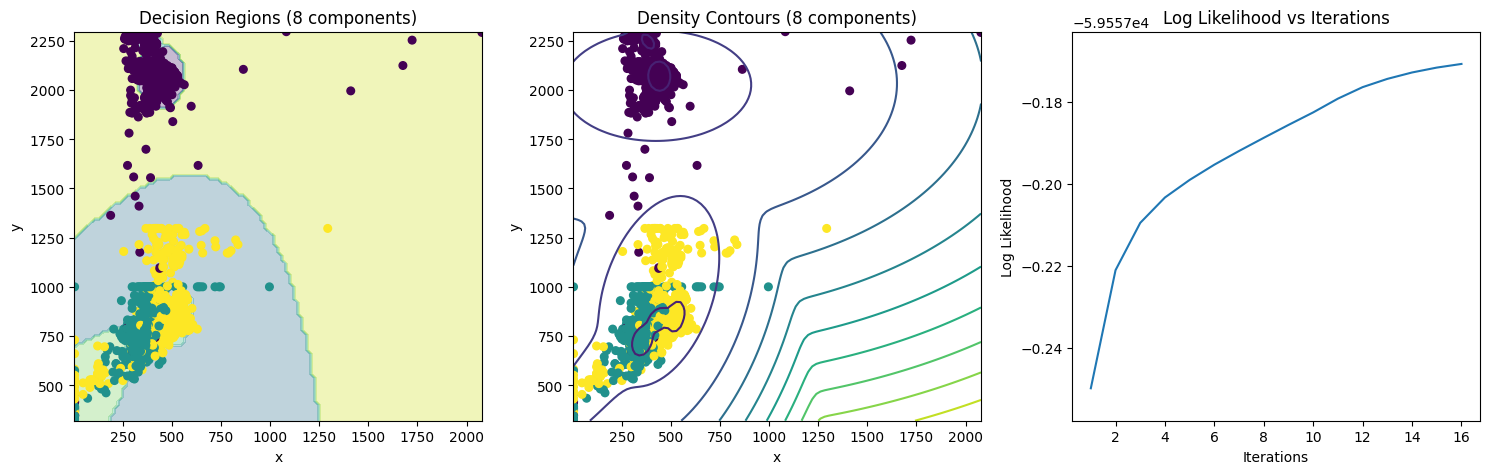


==== GMM with 16 components ====
Accuracy: 0.9046, Precision: 0.9091, Recall: 0.9054, F1: 0.9055


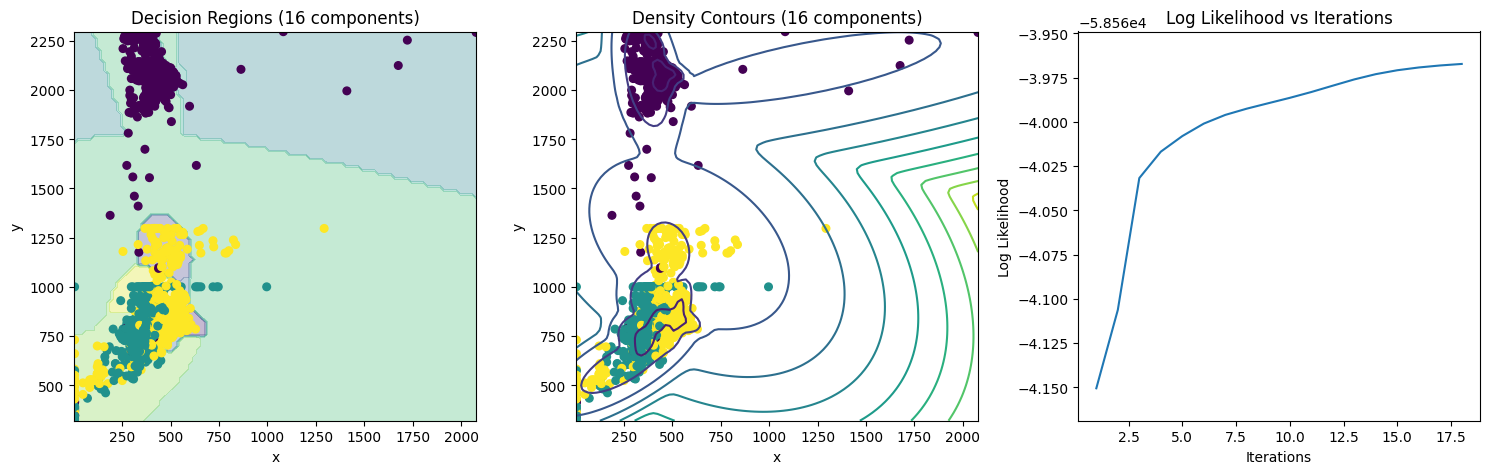


==== GMM with 32 components ====
Accuracy: 0.9088, Precision: 0.9254, Recall: 0.9094, F1: 0.9084


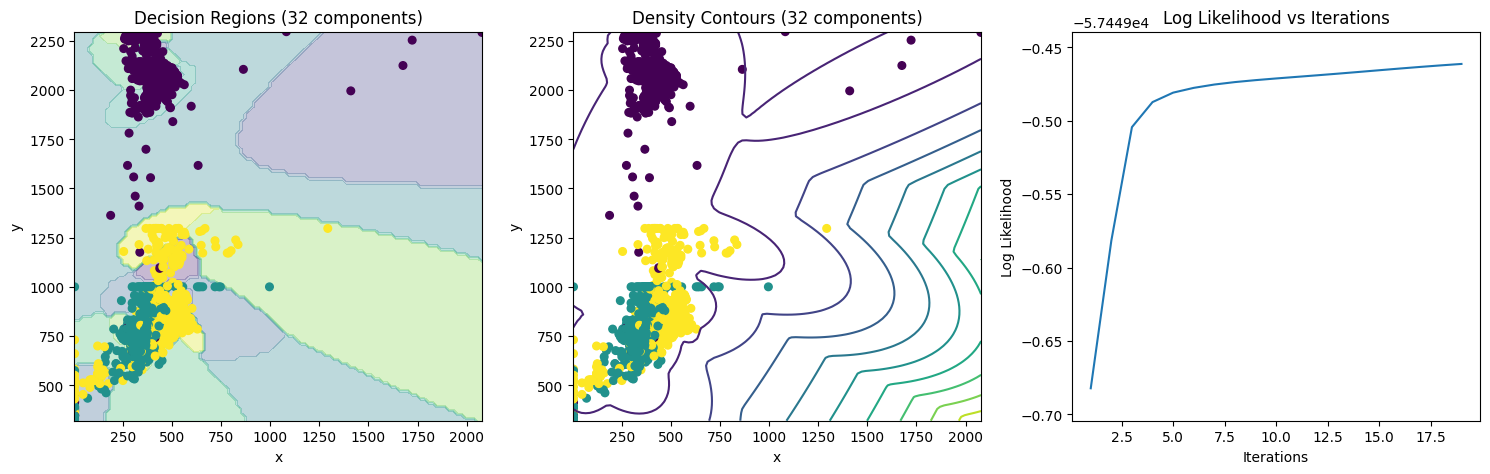


==== GMM with 64 components ====
Accuracy: 0.9419, Precision: 0.9428, Recall: 0.9425, F1: 0.9426


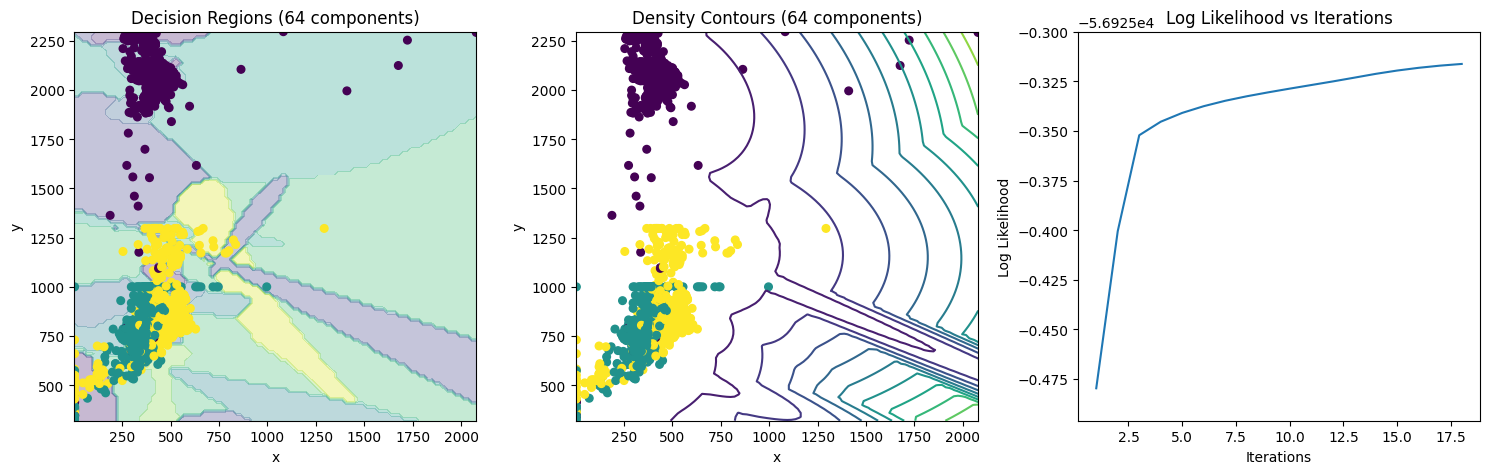

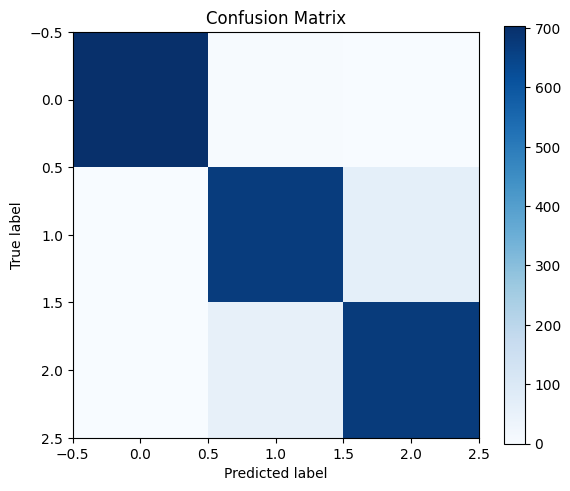

In [17]:
for n in n_mixtures:
    print(f"\n==== GMM with {n} components ====")

    # Initialize with KMeans
    kmeans = KMeans(n_clusters=n, random_state=0).fit(X_train)

    # Create and fit GMM with history tracking
    gmm = GaussianMixture(
        n_components=n,
        covariance_type='full',
        random_state=0,
        max_iter=100,
        tol=1e-3,
        init_params='kmeans'
    )

    # Fit GMM and capture log likelihood
    gmm, log_likelihood_history = fit_gmm_with_log_likelihood(gmm, X_train)

    # Predict and map labels
    y_pred = gmm.predict(X_test)
    y_mapped = map_labels(y_test, y_pred)

    # Calculate metrics
    acc = accuracy_score(y_test, y_mapped)
    prec = precision_score(y_test, y_mapped, average='macro')
    rec = recall_score(y_test, y_mapped, average='macro')
    f1 = f1_score(y_test, y_mapped, average='macro')

    # Store metrics
    all_metrics.append({
        'Components': n,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    # Create visualization plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Data with decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = gmm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axes[0].contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap='viridis')
    axes[0].set_title(f'Decision Regions ({n} components)')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')

    # Plot 2: Density contours
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = -gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axes[1].contour(xx, yy, Z, levels=10, cmap='viridis')
    axes[1].scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap='viridis')
    axes[1].set_title(f'Density Contours ({n} components)')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')

    # Plot 3: Log likelihood vs iterations
    if len(log_likelihood_history) > 0:
        axes[2].plot(range(1, len(log_likelihood_history) + 1), log_likelihood_history)
        axes[2].set_title('Log Likelihood vs Iterations')
        axes[2].set_xlabel('Iterations')
        axes[2].set_ylabel('Log Likelihood')

        # Set appropriate y-limits for better visualization
        y_range = max(log_likelihood_history) - min(log_likelihood_history)
        if y_range > 0:
            y_min = min(log_likelihood_history) - 0.1 * y_range
            y_max = max(log_likelihood_history) + 0.1 * y_range
            axes[2].set_ylim([y_min, y_max])
    else:
        axes[2].text(0.5, 0.5, 'No convergence data available',
                    horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()

    # Plot confusion matrix for the last model
    if n == max(n_mixtures):
        cm = confusion_matrix(y_test, y_mapped)
        plt.figure(figsize=(6, 5))
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.colorbar()
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.tight_layout()
        plt.show()

In [18]:
# Create and display metrics table
metrics_df = pd.DataFrame(all_metrics)
metrics_df = metrics_df.set_index('Components')
metrics_df = metrics_df.round(4)  # Round to 4 decimal places

# Display the table
print("\n=== GMM Performance Metrics ===")
print(metrics_df.to_string())


=== GMM Performance Metrics ===
            Accuracy  Precision  Recall  F1 Score
Components                                       
1             0.3382     0.1127  0.3333    0.1685
2             0.6613     0.4999  0.6638    0.5540
4             0.6719     0.6932  0.6744    0.6094
8             0.8908     0.9009  0.8921    0.8914
16            0.9046     0.9091  0.9054    0.9055
32            0.9088     0.9254  0.9094    0.9084
64            0.9419     0.9428  0.9425    0.9426
